<a href="https://colab.research.google.com/github/94spinoza/Code-Blocks/blob/main/Company%20Bankruptcy%20Prediction(Logistic%20Regression)" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle 데이터 불러오기

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hyeonchunglee","key":"4985f907818830f18663d6ce6537fa9d"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

# 파일 다운로드
!kaggle datasets download -d fedesoriano/company-bankruptcy-prediction

  0% 0.00/4.63M [00:00<?, ?B/s]
100% 4.63M/4.63M [00:00<00:00, 42.7MB/s]


In [3]:
!unzip company-bankruptcy-prediction.zip

Archive:  company-bankruptcy-prediction.zip
  inflating: data.csv                


## 기준모델

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


df_origin = pd.read_csv("data.csv")
df, df_test = train_test_split(df_origin, test_size=0.2)

target = ['Bankrupt?']


## 기준 모델
base_accuracy = df_test[target].value_counts(normalize=True)[0]
print("기준모델 정확도: ", base_accuracy)

기준모델 정확도:  Bankrupt?
0            0.967009
dtype: float64


## Oversampling 통해 데이터 편향 해결

In [11]:
from imblearn.over_sampling import SMOTE


## Oversampling 통해 데이터 편향 해결
oversample = SMOTE(random_state=2)

X_a = df.drop(labels=target, axis=1)
y_a = df[target]

X, y = oversample.fit_resample(X_a, y_a)
X = pd.DataFrame(X, columns=X_a.columns)
y = pd.DataFrame(y, columns=['Bankruptcy?'])

print("Oversampling 이후 기준모델 정확도: ", y.value_counts(normalize=True)[0])

Oversampling 이후 기준모델 정확도:  Bankruptcy?
0              0.5
dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Train & Validation Data Split

In [12]:
## Train & Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## <Model 2>
## Logistic Regression 학습시키기

In [13]:
pip install category_encoders

     |████████████████████████████████| 81kB 6.4MB/s 


In [58]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


## Logistic Regression
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(random_state=2)
)

pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=2,


## Logistic Regression 예측하기

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      4238
           1       0.90      0.92      0.91      4210

    accuracy                           0.91      8448
   macro avg       0.91      0.91      0.91      8448
weighted avg       0.91      0.91      0.91      8448

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1042
           1       0.90      0.91      0.91      1070

    accuracy                           0.91      2112
   macro avg       0.91      0.91      0.91      2112
weighted avg       0.91      0.91      0.91      2112

AUC: 0.9052487129352252


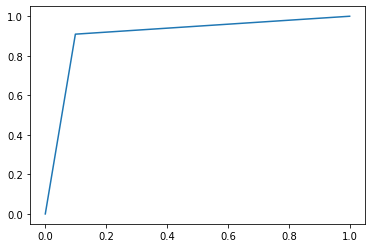

In [59]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import numpy as np


## 데이터 예측하기
y_train_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)

## Confusion Matrix 출력
print(classification_report(y_train,y_train_pred))
print(classification_report(y_val,y_val_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

## Permutation Importance 알아보기

In [17]:
pip install eli5

     |████████████████████████████████| 112kB 33.6MB/s 


In [61]:
from sklearn.pipeline import Pipeline
import warnings
import eli5
from eli5.sklearn import PermutationImportance

## Permutation Importance 활용
# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다
pipe_per = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer(), StandardScaler())),
    ('lr', LogisticRegression(random_state=2)) 
])

pipe_per.fit(X_train, y_train)


## Permutation Part
warnings.simplefilter(action='ignore', category=FutureWarning)

# permuter 정의
permuter = PermutationImportance(
    pipe_per.named_steps['lr'], # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe_per.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=2,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                      n_iter=5, random_state=2, refit=True, scoring='roc_auc')

In [62]:
feature_names = X_val.columns.tolist()
print("총 변수의 개수 : ", len(feature_names))
pd.Series(permuter.feature_importances_, feature_names).sort_values()

총 변수의 개수 :  95


 Total Asset Growth Rate                   -0.000307
 Interest Expense Ratio                    -0.000174
 Operating Gross Margin                    -0.000046
 Long-term Liability to Current Assets     -0.000029
 No-credit Interval                        -0.000023
                                              ...   
 Cash/Total Assets                          0.022957
 Borrowing dependency                       0.069311
 Net Value Per Share (B)                    0.100340
 Net Income to Total Assets                 0.150842
 Persistent EPS in the Last Four Seasons    0.214381
Length: 95, dtype: float64

In [65]:
 ## 중요하지 않은 변수 삭제
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]

X_train_selected = X_train[features]
X_val_selected = X_val[features]


## 삭제 후 새로운 Pipeline
pipe_sel = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer(), StandardScaler())),
    ('lr', LogisticRegression(random_state=2)) 
], verbose=1)

pipe_sel.fit(X_train_selected, y_train)

print("총 변수의 개수 : ", len(X_val_selected.columns.tolist()))
print('시험 정확도 : ', pipe_sel.score(X_val_selected, y_val))

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.2s
총 변수의 개수 :  40
시험 정확도 :  0.8991477272727273


## Permutation Importance 분석으로 불필요한 변수 삭제 후 성능

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1042
           1       0.90      0.90      0.90      1070

    accuracy                           0.90      2112
   macro avg       0.90      0.90      0.90      2112
weighted avg       0.90      0.90      0.90      2112

AUC: 0.8991111629325345


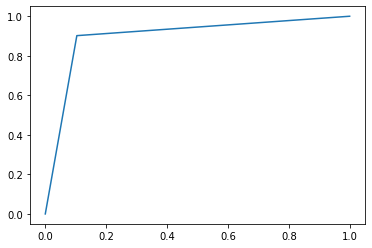

In [66]:
## Confusion Matrix 출력
y_val_selected_pred = pipe_sel.predict(X_val_selected)
print(classification_report(y_val, y_val_selected_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_val, y_val_selected_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

## Oversampling하여 학습한 모델을 비대칭적인 데이터셋에 적용

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1319
           1       0.19      0.73      0.31        45

    accuracy                           0.89      1364
   macro avg       0.59      0.81      0.62      1364
weighted avg       0.96      0.89      0.92      1364

AUC: 0.8147333838766742


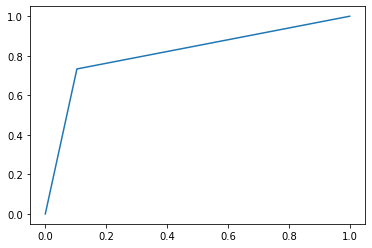

In [67]:
X_test = df_test.drop(labels=target, axis=1)
X_test_selected = X_test[features]
y_test = df_test[target]

## Confusion Matrix 출력
y_test_selected_pred = pipe_sel.predict(X_test_selected)
print(classification_report(y_test, y_test_selected_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_test, y_test_selected_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

## 모두 파산 안한다고(0) 예측할 경우

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1319
           1       0.00      0.00      0.00        45

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.94      0.97      0.95      1364

AUC: 0.5


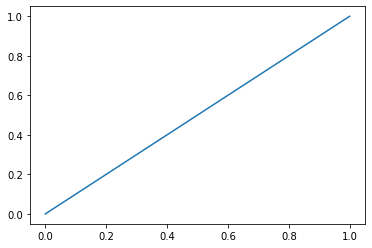

In [68]:
y_deny = pd.DataFrame({'Bankruptcy?':[0]*1364})

## Confusion Matrix 출력
print(classification_report(y_test, y_deny))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_test, y_deny, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

변수들을 많이 삭제했음에도 성능을 아주 약간밖에 떨어지지 않음

## Oversampling하지 않고 학습한 모델의 성능

Bankrupt?
0            0.967919
1            0.032081
dtype: float64
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1319
           1       0.64      0.16      0.25        45

    accuracy                           0.97      1364
   macro avg       0.80      0.58      0.62      1364
weighted avg       0.96      0.97      0.96      1364

AUC: 0.5762614775503326


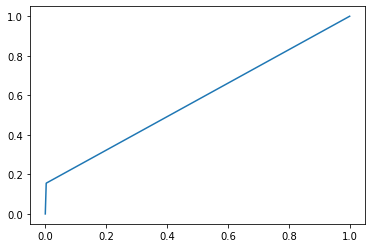

In [73]:
## 원래 데이터에 모델 대입해보기
## 기준모델
base_accuracy_origin = df[target].value_counts(normalize=True)
print(base_accuracy_origin)

### 기본적인 모델
pipe_org = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(random_state=2)
)

# 중요한 Featrues 추출 후 모델 Fit
X_origin = df.drop(labels=target, axis=1)[features]
y_origin = df[target]
pipe_org.fit(X_origin, y_origin)

## Confusion Matrix 출력
y_test_origin_pred = pipe_org.predict(X_test_selected)
print(classification_report(y_test, y_test_origin_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_test, y_test_origin_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

## PDP & SHAP 활용하여 설명하기

In [74]:
pip install pdpbox

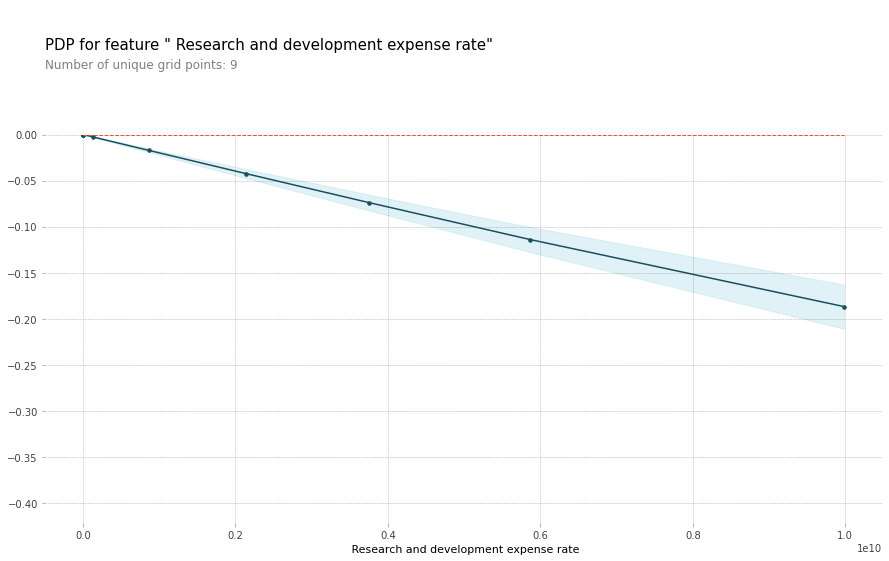

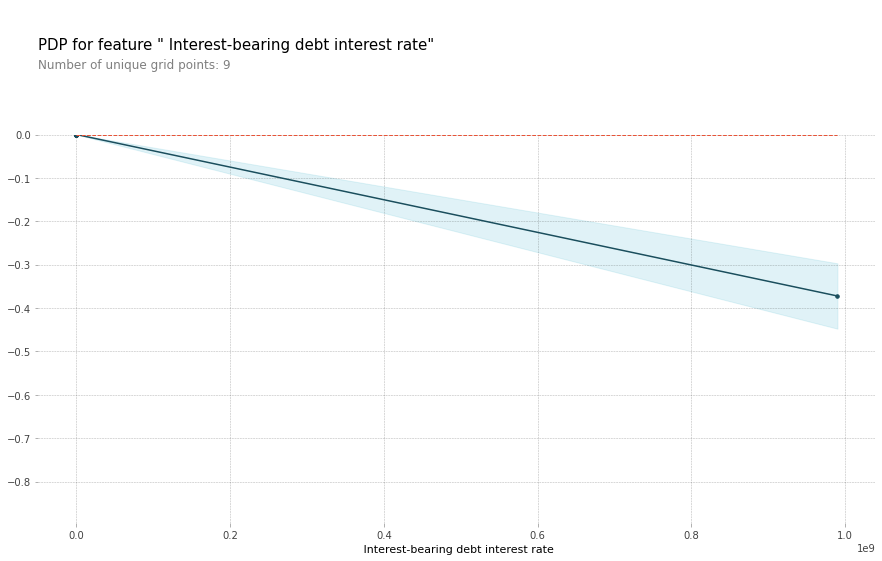

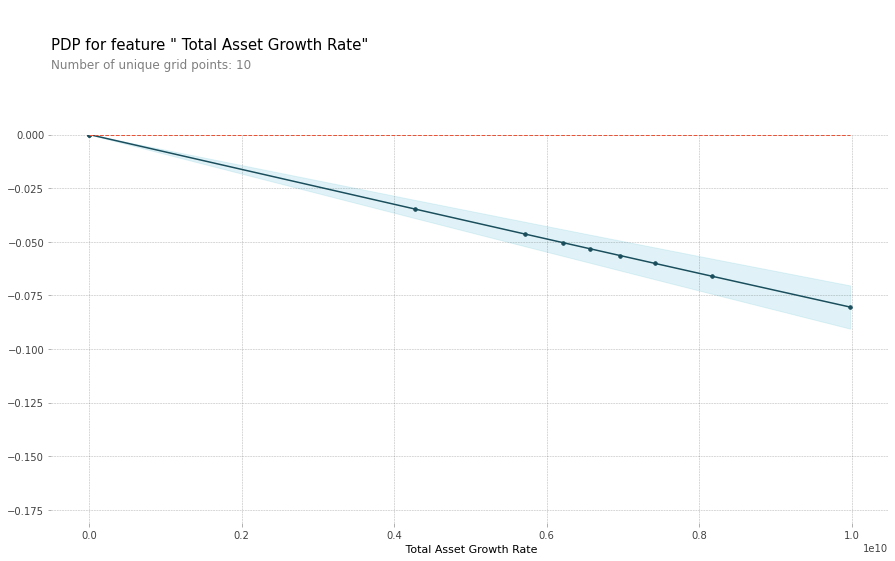

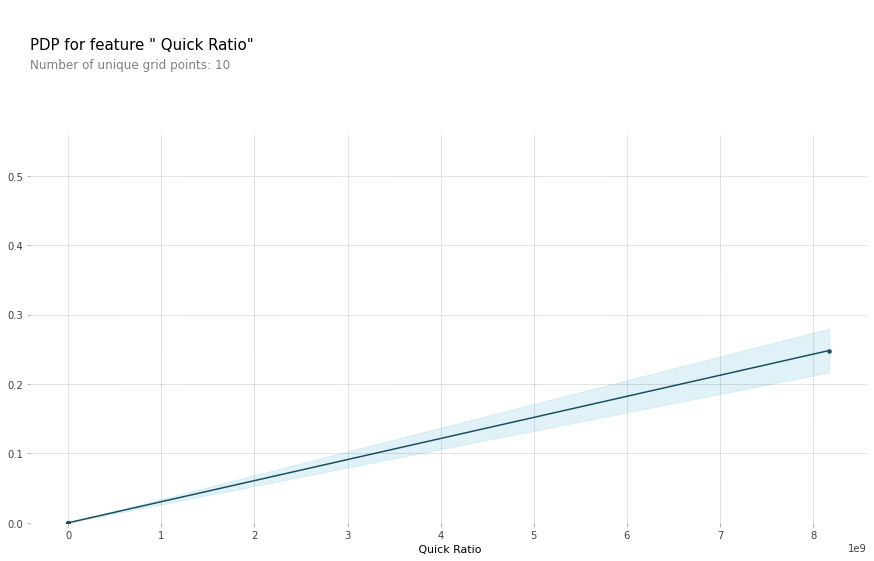

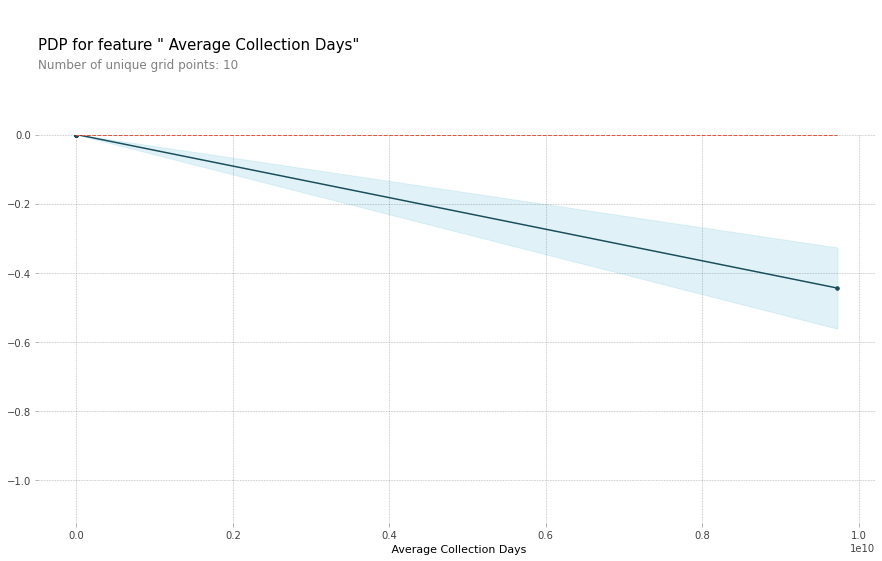

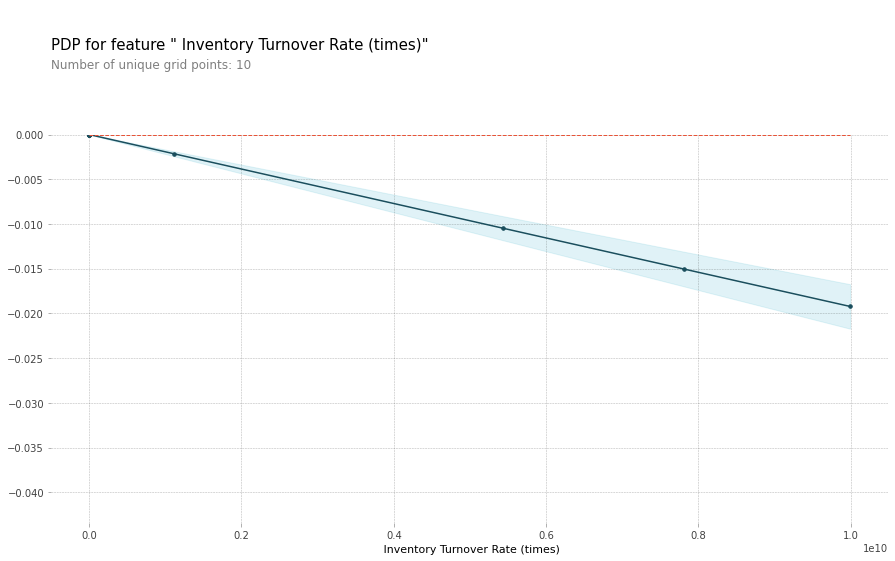

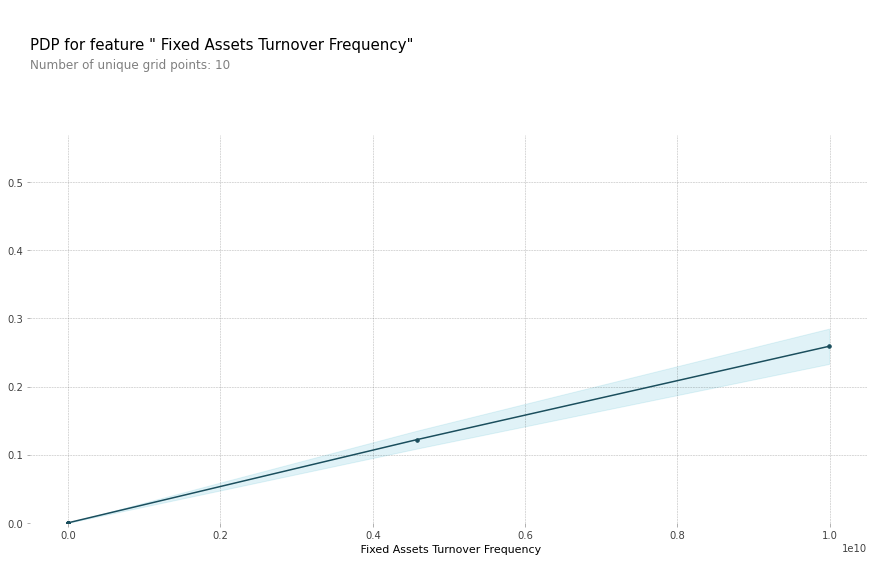

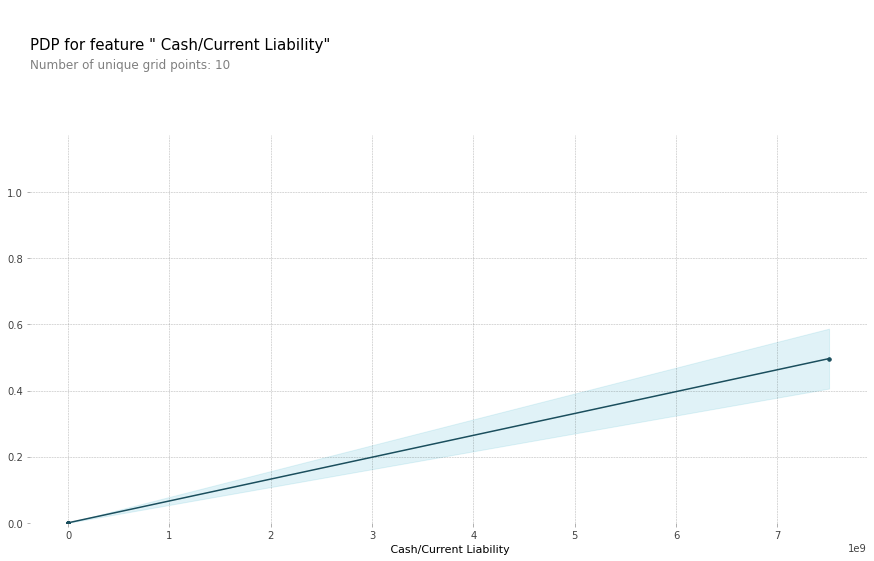

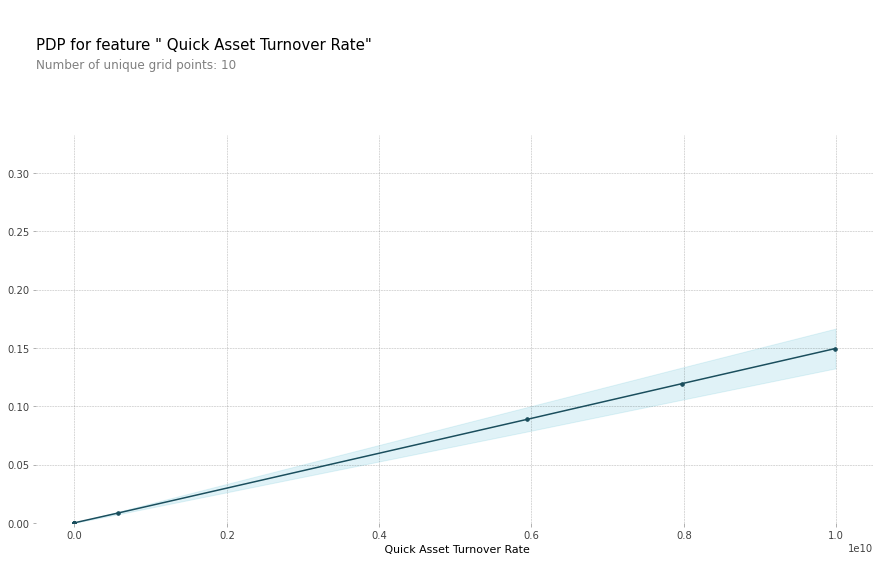

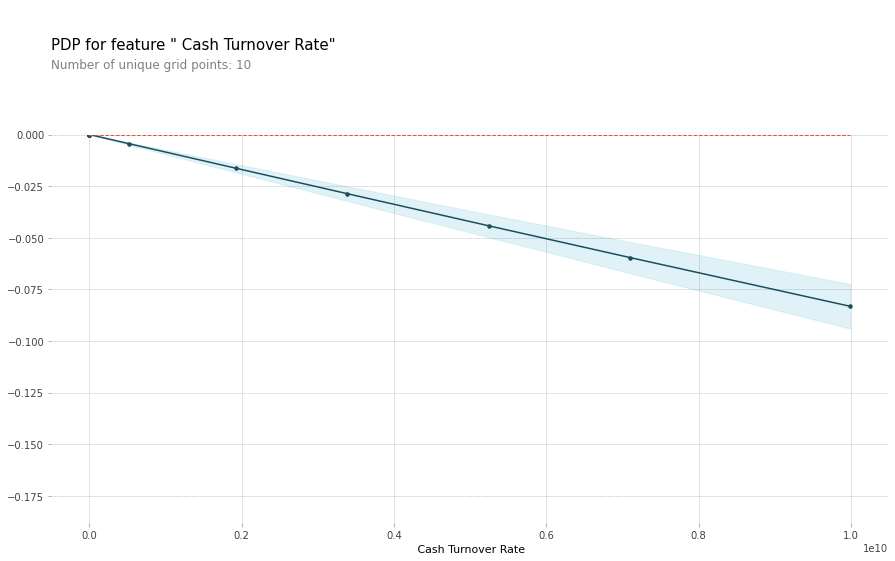

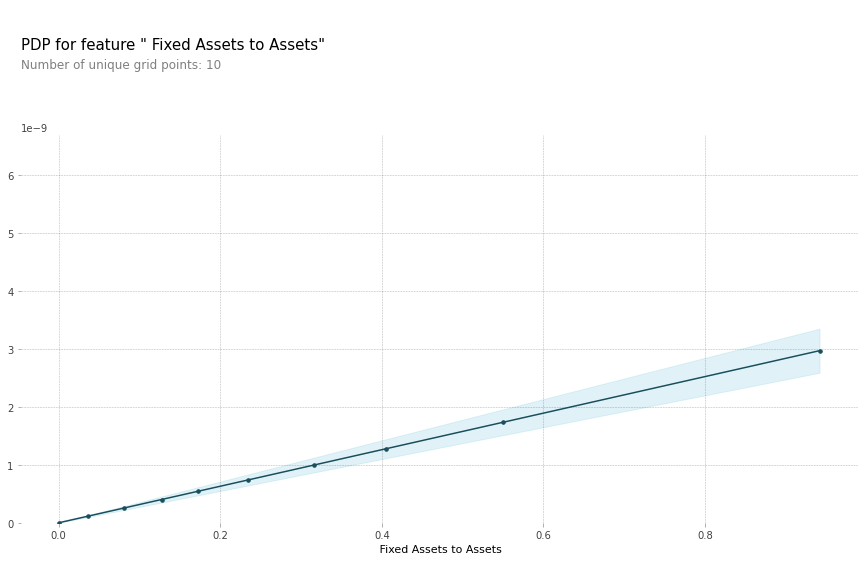

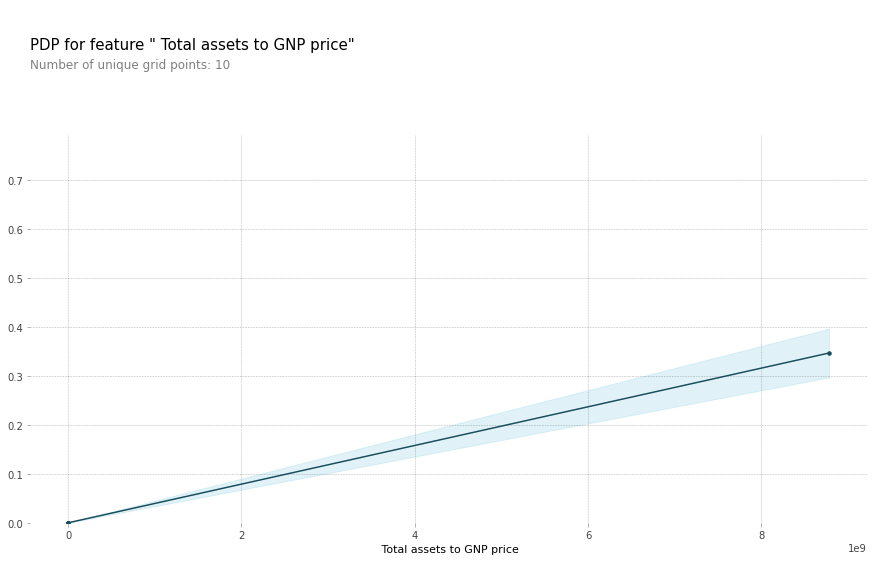

In [35]:
import matplotlib.pyplot as plt
from pdpbox import pdp


preprocessing = pipe_sel.named_steps['preprocessing']
X_preprocessed = preprocessing.fit_transform(X_test_selected)
X_preprocessed = pd.DataFrame(columns=features, data=X_preprocessed)
lr = pipe_sel.named_steps['lr']

for feature in features:
  pdp_dist = pdp.pdp_isolate(model=lr, dataset=X_preprocessed, model_features=features, feature=feature)
  pdp.pdp_plot(pdp_dist, feature)

In [37]:
pip install shap

     |████████████████████████████████| 358kB 30.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491629 sha256=60eb9552f70c0d17282c5528fc2a915c16e6b9c815952e4fed0f8188932f3dcb
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


Permutation explainer: 1001it [00:28, 35.75it/s]                         


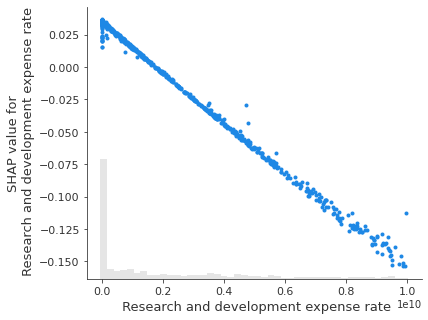

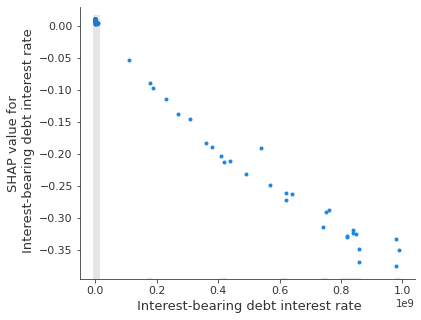

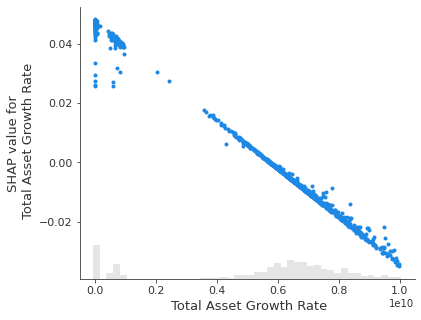

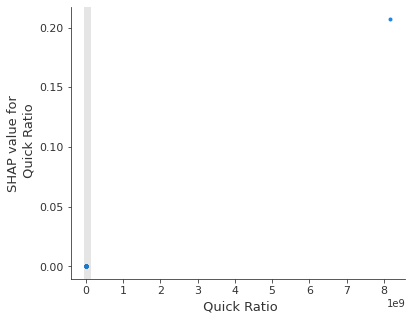

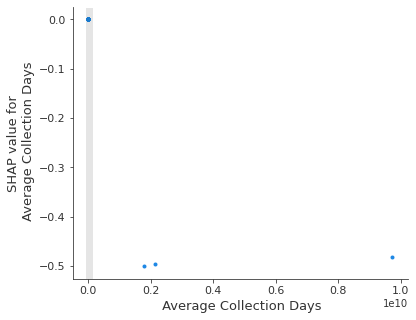

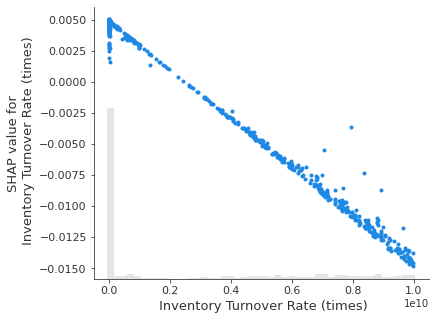

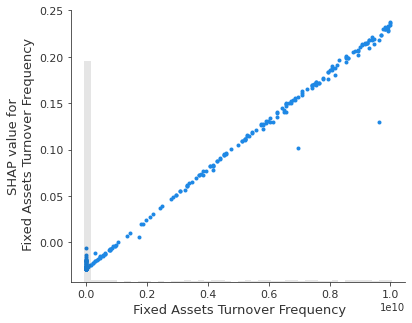

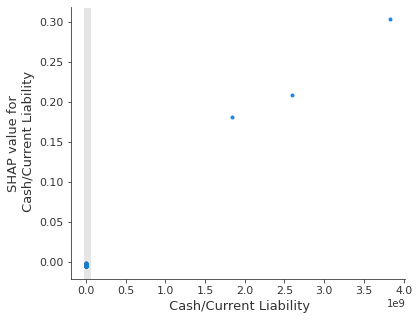

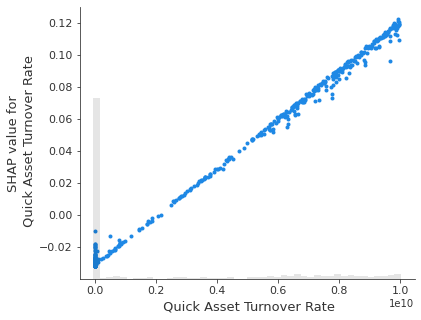

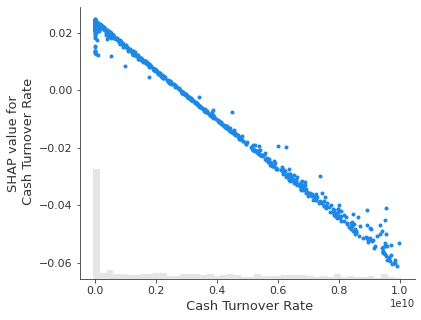

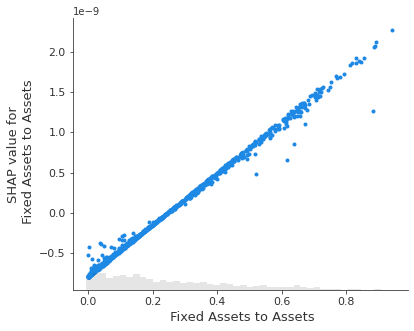

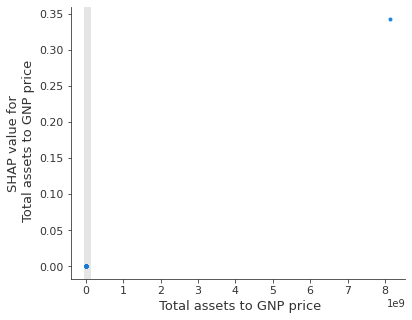

In [45]:
import shap


### SHAP
def pipe_sel_proba(x):
    return pipe_sel.predict_proba(x)[:,1]

background = shap.maskers.Independent(X_test_selected, max_samples=100)
explainer = shap.Explainer(pipe_sel_proba, background)
shap_values = explainer(X_test_selected[:1000])

for feature in features:
  shap.plots.scatter(shap_values[:, feature])

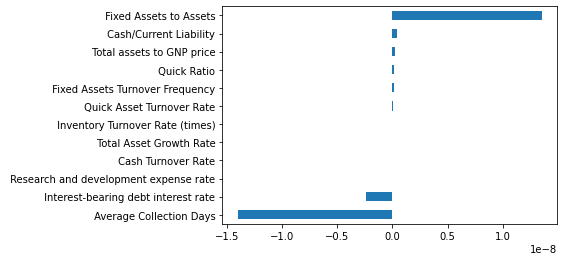

In [50]:
coefficients = pd.Series(lr.coef_[0], X_test_selected.columns)
coefficients.sort_values().plot.barh()

In [56]:
## Permutation Part
warnings.simplefilter(action='ignore', category=FutureWarning)

# permuter 정의
permuter_sel = PermutationImportance(
    pipe_sel.named_steps['lr'], # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_test_transformed = pipe_sel.named_steps['preprocessing'].transform(X_test_selected)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter_sel.fit(X_test_transformed, y_test)

PermutationImportance(cv='prefit',
                      estimator=LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=2,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                      n_iter=5, random_state=2, refit=True, scoring='roc_auc')

In [57]:
feature_names = X_test_selected.columns.tolist()
print("총 변수의 개수 : ", len(feature_names))
pd.Series(permuter_sel.feature_importances_, feature_names).sort_values()

총 변수의 개수 :  12


 Inventory Turnover Rate (times)         -0.002605
 Fixed Assets to Assets                   0.000000
 Quick Ratio                              0.000256
 Average Collection Days                  0.000569
 Cash/Current Liability                   0.000751
 Research and development expense rate    0.004593
 Quick Asset Turnover Rate                0.005388
 Interest-bearing debt interest rate      0.008100
 Total assets to GNP price                0.018148
 Cash Turnover Rate                       0.018944
 Total Asset Growth Rate                  0.027475
 Fixed Assets Turnover Frequency          0.080064
dtype: float64